# V Score the model on Test Dataset split 

- This version is scores all model revision with rouge metrics 

- [V 0.0](https://www.kaggle.com/code/yannchikk/first-experience-in-peft-nlp-sum-model-lora?scriptVersionId=171845611) is the first model training baseline: Model **Initialiazation, Configuration, and training** until 6 epoch 

- [v 1.0](https://www.kaggle.com/code/yannchikk/first-experience-in-peft-nlp-sum-model-lora?scriptVersionId=171944212) continues training process untill **12 epochs**

**Tottaly**: There are summarization models LoRA trained on augmented dataset.

In [1]:
class Config:
    
    max_length = 1024
    target_max_length = 512

    epochs = 8
    
    batch_size = 8
    
    model_preset = "doublecringe123/bardt-large-cnn-dialoguesum-booksum-lora"
    revisions = [
#         Training run 2 
        "cbdcb69f711f68a195ac05d2c42bcceac2d569a9", # 12 epochs
        "2eacf0ebbc23d62961daedfade5d3a3832608e09", # 10 epochs
        "42401e466978651ef54c0d84cb317ade936dec70", # 8 epochs
        
#         Training run 1 
        "977b188e7970f1c88f167d30656f32a63787e68b", # 6 epochs 
        "4eb6da5df9bcd7584572e062bd671b5929659204", # 4 epochs 
        "a9fdb96992ce3152177583d39cfce6e5843b5053", # 2 epochs
    ]
    
    generation_parameters = {
        'max_length': 512, 
        'do_sample': True, 
        'num_beams': 3, 
    }
    
    inp = 'input_content'
    target = 'target'

cfg = Config()

# At First, lets load datasets



In [2]:
! pip install -q --upgrade pip
! pip install -q transformers[torch]
! pip install -q -U transformers==4.38.2 datasets==2.18.0 evaluate rouge_score peft

import os
from kaggle_secrets import UserSecretsClient

os.environ["HF_TOKEN"] = UserSecretsClient().get_secret("HF_TOKEN")

try: 
    import wandb
    wandb.init(mode='disabled')
except: 
    ...
    
# Check the datasets lib version
# It have to be the latest v.
import datasets 

print(datasets.__version__)

2.18.0


This is my code from [github repo](https://github.com/goin2crazy/multy-dataset/blob/main/main.py) 

In [3]:
! wget -O "mds.py" "https://raw.githubusercontent.com/goin2crazy/multy-dataset/main/main.py" 

--2024-04-15 14:09:42--  https://raw.githubusercontent.com/goin2crazy/multy-dataset/main/main.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2333 (2.3K) [text/plain]
Saving to: 'mds.py'

mds.py              100%[===================>]   2.28K  --.-KB/s    in 0s      

2024-04-15 14:09:42 (24.6 MB/s) - 'mds.py' saved [2333/2333]



# Prepare Dataset

In [4]:
from mds import NewDataset
dataset_params = {
    "knkarthick/dialogsum": ("dialogue", "summary"), 
    "doublecringe123/dialoguesum-npc-dialoguesum-stemmed-augmented": ('inp', 'target')
}

dataset = NewDataset(dataset_params, input_col_name = cfg.inp, target_col_name = cfg.target)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split:   0%|          | 0/59070 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7000 [00:00<?, ? examples/s]

# Tokenize Dataset

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

def preprocess_function(examples):
    try: 
        inputs = [doc for doc in examples[cfg.inp]]
        model_inputs = tokenizer(inputs, max_length=cfg.max_length, truncation=True)

        labels = tokenizer(text_target=examples[cfg.target], max_length=cfg.target_max_length, truncation=True)

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    except TypeError as e:
        print(e)
        print(examples[cfg.inp])

dataset = dataset.map(preprocess_function, batched = True, remove_columns=[cfg.inp, cfg.target])
tokenized_train, tokenized_val, tokenized_test = dataset.splits

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/71530 [00:00<?, ? examples/s]

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

In [6]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=cfg.model_preset)

2024-04-15 14:10:38.051988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 14:10:38.052129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 14:10:38.194030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Define Metrics

In [7]:
import evaluate

rouge = evaluate.load("rouge")

In [8]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions, labels = predictions.cpu(), labels.cpu()
    
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

# Validate LoRA models revisions 

In [9]:
import torch
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd 
from tqdm.autonotebook import tqdm

def metrics_mean(met_lst):
    d = pd.DataFrame(met_lst)
    return {col: d[col].mean() for col in d.columns}
#     get all names from first item

def validate(dataset, model, tokenizer, batch_size=8, generate = False):
    model.eval()  # Set model to evaluation mode
    
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        collate_fn=data_collator, 
        drop_last=False
    )
    
    metrics_lst = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].to(model.device)

            if generate==True: 
                outputs = model.generate(input_ids, attention_mask=attention_mask, labels=labels, **cfg.generation_parameters)
                
                metrics = compute_metrics((outputs, labels))
            else: 
#                 ???
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                logits = outputs.logits

                metrics = compute_metrics((output, logits))
            metrics_lst.append(metrics)
    # Compute your metrics using decoded_preds and decoded_labels

    return metrics_lst

In [10]:
from peft import PeftModel, PeftConfig
from transformers import  AutoModelForSeq2SeqLM, AutoTokenizer
from torch.nn import DataParallel

revisions = cfg.revisions

model_results = []
for v in revisions: 
    config = PeftConfig.from_pretrained(cfg.model_preset, revision = v)
    
    model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
    
    lora_model = PeftModel.from_pretrained(model, cfg.model_preset) 
    
    print(f"Version {v}")
    lora_model.print_trainable_parameters() 
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    lora_model.model = DataParallel(lora_model.model) 
    
    val = validate(dataset = tokenized_test.select(range(1000)), 
                   model = lora_model, generate=True, 
                   tokenizer = tokenizer, 
                   batch_size = cfg.batch_size)
#     mean all metrics 
    val = metrics_mean(val)
    model_results.append((v, val))

adapter_config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Version cbdcb69f711f68a195ac05d2c42bcceac2d569a9
trainable params: 0 || all params: 408,059,904 || trainable%: 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

Version 2eacf0ebbc23d62961daedfade5d3a3832608e09
trainable params: 0 || all params: 408,059,904 || trainable%: 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

Version 42401e466978651ef54c0d84cb317ade936dec70
trainable params: 0 || all params: 408,059,904 || trainable%: 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

Version 977b188e7970f1c88f167d30656f32a63787e68b
trainable params: 0 || all params: 408,059,904 || trainable%: 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

Version 4eb6da5df9bcd7584572e062bd671b5929659204
trainable params: 0 || all params: 408,059,904 || trainable%: 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

Version a9fdb96992ce3152177583d39cfce6e5843b5053
trainable params: 0 || all params: 408,059,904 || trainable%: 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

In [11]:
scores_df = pd.DataFrame([val for (_, val) in model_results])
scores_df.index = [v[:4] for (v, _) in model_results]
scores_df

,rouge1,rouge2,rougeL,rougeLsum,gen_len
cbdc,0.354368,0.134549,0.269332,0.269214,61.377
2eac,0.356398,0.136184,0.271832,0.271867,61.449
4240,0.355003,0.134951,0.270445,0.270376,61.397
977b,0.353860,0.138336,0.270086,0.270095,61.624
4eb6,0.355826,0.135294,0.267504,0.267437,61.474
a9fd,0.355908,0.135696,0.267895,0.267801,61.509


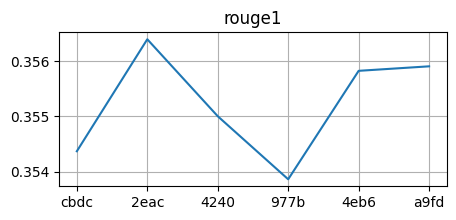

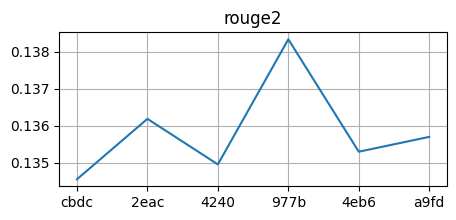

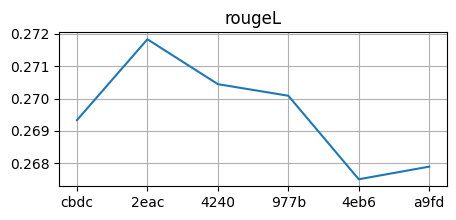

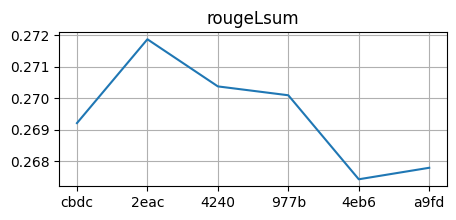

In [12]:
import matplotlib.pyplot as plt

data = scores_df
# Plot each ROUGE column

# Plot

for rouge_column in ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']:
    plt.figure(figsize=(5, 2))
    
    plt.plot(data.index, data[rouge_column], label=rouge_column)
    
    plt.title(rouge_column)
    plt.grid(True)
    plt.show() 